# Clothes detection with

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">


# Import detectron2 utils

In [1]:
import torch
assert torch.__version__.startswith("1.8")
print(torch.__version__, torch.cuda.is_available())

1.8.1+cu102 True


In [2]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import cv2
import random

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Setup

### Empty cache

In [3]:
torch.cuda.empty_cache()


### Prepare the dataset

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("deepfashion_train", {}, "./dataset/detectron_annos/train_annos_all.json", "./dataset/train/image/")
register_coco_instances("deepfashion_validation", {}, "./dataset/detectron_annos/validation_annos_all.json", "./dataset/validation/image")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [5]:
dataset_dicts = DatasetCatalog.get("deepfashion_train")
clothes_metadata = MetadataCatalog.get("deepfashion_train")

[08/28 20:04:39 d2.data.datasets.coco]: Loading ./dataset/detectron_annos/train_annos_all.json takes 49.48 seconds.
[08/28 20:04:40 d2.data.datasets.coco]: Loaded 191961 images in COCO format from ./dataset/detectron_annos/train_annos_all.json


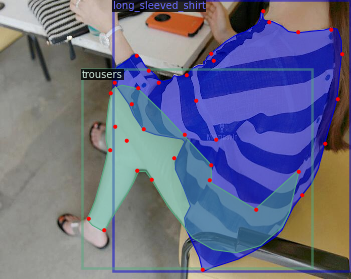

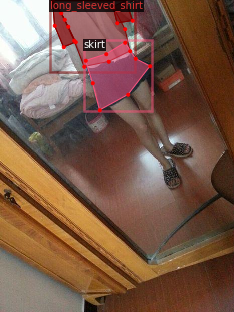

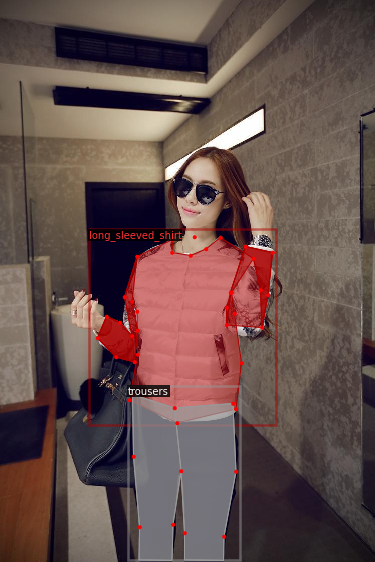

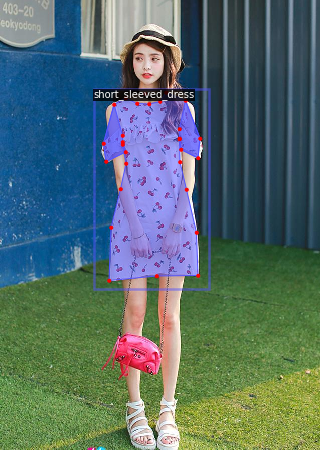

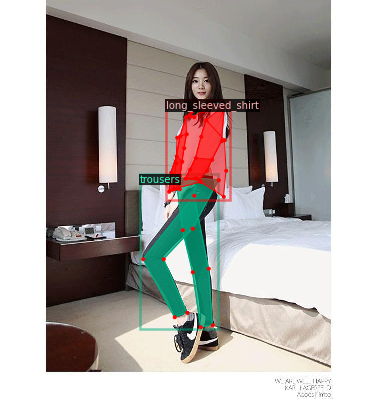

In [6]:
from PIL import Image

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=clothes_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    img_pil = Image.fromarray(out.get_image(), 'RGB')
    display(img_pil)

### config

In [7]:
from clothes_detection.trainer import Trainer

cfg = get_cfg()
cfg.merge_from_file("./configs/Faster_RCNN_R101_FPN_3x.yaml")
trainer = Trainer(cfg)

[08/28 20:05:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[08/28 20:06:08 d2.data.datasets.coco]: Loading ./dataset/detectron_annos/train_annos_all.json takes 50.21 seconds.
[08/28 20:06:08 d2.data.datasets.coco]: Loaded 191961 images in COCO format from ./dataset/detectron_annos/train_annos_all.json
[08/28 20:07:11 d2.data.build]: Removed 0 images with no usable annotations. 191961 images left.
[08/28 20:07:21 d2.data.build]: Distribution of instances among all 13 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| short_sleev.. | 71645        | long_sleeve.. | 36064        | short_sleev.. | 543          |
| long_sleeve.. | 13457        |     vest      | 16095        |     sling     | 1985         |
|    shorts     | 36616        |   trousers    | 55387        |     skirt     | 30835        |
| short_sleev.. | 17211        | long_sleeve.. | 7907         |  vest_dress   | 17949        |
|  sli

### show augmented images

In [ ]:
augmentation_data_loader = trainer.build_train_loader(cfg)

[08/28 20:09:14 d2.data.datasets.coco]: Loading ./dataset/detectron_annos/train_annos_all.json takes 49.84 seconds.
[08/28 20:09:15 d2.data.datasets.coco]: Loaded 191961 images in COCO format from ./dataset/detectron_annos/train_annos_all.json


In [ ]:
from itertools import islice
from detectron2.data import detection_utils as utils

def display_data_loader_img(img):
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)
        
    visualizer = Visualizer(img, metadata=clothes_metadata, scale=0.5)

    target_fields = record["instances"].get_fields()
    class_names = [clothes_metadata.thing_classes[x] for x in target_fields.get("gt_classes", None)]

    out = visualizer.overlay_instances(
        labels = class_names,
        boxes=target_fields.get("gt_boxes", None),
    )

    img_pil = Image.fromarray(out.get_image(), 'RGB')
    display(img_pil)

for batch in islice(augmentation_data_loader, 0, 10):
    for _, record in enumerate(batch[:2]):
        img_augmented = record['image'].permute(1,2,0)
        display_data_loader_img(img_augmented)